# 26.05.2023
### Hubert
- Create function for clustering
- Cluster crime dataset

# 1.06.2023
### Hubert
- Use Mateys code for table pivoting
- restructure education, income and population datasets
- reformat education, income and population datasets
- Apply SVC classification model
- Research about SMOTE with goal to augment dataset and addres imbalance of the dataset
- Add visualization of feature importance to linear SVC
 
### Matey
- Hyperparameter tuning

# 5.06.2023
### Hubert
- Added coments
- combined genders in the same age
- Tried to work with 2 classess for clustering

# 6.06.2023
### Maikel
- tried adding qol to the merged dataset but there is no data on qol for 2019.
- tried changing all the years to the same year but there is missing data for some years.
- tried to interpolate QoL for 2019 from 2018 and 2020

### Hubert
- Fixed interpolation, needed to replace strin ',' with '.' and convert to float before calculating mean

# 8.06.2023
### Maikel
- cleaned both hubert and matey's model so that they are production level ready.

In [1]:
import pandas as pd
from sklearn.cluster import BisectingKMeans, KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna

In [2]:
#Load the data
#@Author Hubert
crime_rate = pd.read_csv("../data/Misdrijven_per_wijk_en_buurt_per_maand_15052023_134652.csv", sep=";")
education = pd.read_csv("../data/processed/educational_level_neighbourhood_of_Gemeente_Breda_processed.csv", sep=",")
income = pd.read_csv("../data/processed/income_level_neighbourhood_of_Gemeente_Breda_processed.csv", sep=",")
population = pd.read_csv("../data/processed/Population_of_neighbourhood_of_Gemeente_Breda_processed.csv")
# qol_of_Breda = pd.read_csv('../data/processed/QOL_of_Gemeente_Breda_processed.csv')
df_qol = pd.read_csv('../data/Totaalscore Leefbaarometer 3.0 - Buurten van Gemeente Breda.csv', sep=';')

#Remove columns that were created as an artefact douring cleaning
del income['Unnamed: 0']
del education['Unnamed: 0']
del population['Unnamed: 0']
del df_qol['Unnamed: 0']

# Functions

In [3]:
def cluster(df, n_clust):
    """
    @author Hubert
    Perform K-means clustering on a DataFrame based on unique years.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame to be clustered for unique years
    n_clust : int
        Number of clusters to be returned
    
    Returns
    --------
    pandas DataFrame
        DataFrame with added cluster Labels

    
    Notes
    -----
    Ensure correct index, neighbourhood name should be set as index and Not as column.
    """

    #Extract list of unique years
    years = df['Year'].unique()
    for i, year in enumerate(years):
        #Select one year from DataFrame
        df_t = df[df['Year'] == year]
        #Perform clustering
        kmeans = KMeans(n_clusters=n_clust, random_state=None).fit(df_t)
        df_t['ClusterLabel'] = kmeans.labels_

        #Create new DataFrame on first iteration and append next iterations
        if i == 0:
            cluster = df_t
        else:
            cluster = pd.concat([cluster, df_t])
    return cluster

In [4]:
def f_importances(coef, feature_names, class_names):
    """
    @Author Hubert
    Assigns feature names to corresponding coefficients for each class.

    Parameters
    ----------
    coef : array-like, shape (n_classes, n_features)
        Coefficient values for each feature and class.
        Note: Classification model needs to provide coef_
    feature_names : list
        List of feature names.

    class_names : list
        List of class names.

    Returns
    -------
    dict
        A dictionary containing the coefficients for each class, with feature names as keys.
        
    Notes
    -----
    
    """
        
    # Create a dictionary to store the coefficients for each class
    coefficients = {class_name: {} for class_name in class_names}
    
    # Assign feature names to the corresponding coefficients
    try:
        for i, class_name in enumerate(class_names):
            for j, feature_name in enumerate(feature_names):
                coefficients[class_name][feature_name] = coef[i][j]
    except:
        for j, feature_name in enumerate(feature_names):
                coefficients[feature_name] = coef[0][j]
    
    return coefficients

In [5]:
def plot_coefficients(coef, feature_names, class_names):
    """
    @Author Hubert
    Display a barhplot for each feature and class

    Parameters
    ----------
    coef : array-like, shape (n_classes, n_features)
        Coefficient values for each feature and class.
        Note: Classification model needs to provide coef_
    feature_names : list
        List of feature names.

    class_names : list
        List of class names.
    
    Notes
    -----
    
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2  # Width of each bar
    space_between_bars = 0.05  # Space between bars for different classes

    # Iterate over each class
    for i, class_name in enumerate(class_names):
        # Calculate the x-position for each bar, adding appropriate spacing
        x_pos = np.arange(len(feature_names)) + (bar_width + space_between_bars) * i
    
        # Plot the horizontal bars for the current class
        ax.barh(x_pos, coef[i], height=bar_width, align='center', label=class_name)

    # Set the y-ticks and labels to the feature names
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_yticklabels(feature_names)

    ax.legend()  # Add a legend to the plot
    ax.set_xlabel('Coefficient Value')  # Set the x-axis label
    ax.set_title('Coefficients for Each Class')  # Set the plot title

    plt.show()  # Display the plot

# Data preparation for classification

In [6]:
#@Author Hubert
#Replace '?' with NaN values for classification
education['value'] = education['value'].replace('?',np.NaN)
education

,Buurten,level_of_education,Year,value
0,Valkenberg,Laag,2019,240
1,Chassé,Laag,2019,340
2,Fellenoord,Laag,2019,410
3,Schorsmolen,Laag,2019,390
4,Station,Laag,2019,360
...,...,...,...,...
499,Prinsenbeek,Hoog,2021,3000
500,Buitengebied Prinsenbeek,Hoog,2021,200
501,Teteringen,Hoog,2021,2540
502,Vuchtpolder,Hoog,2021,20


In [7]:
df_educational_level_year = education[education['Year'] == 2019]
df_educational_level_year

,Buurten,level_of_education,Year,value
0,Valkenberg,Laag,2019,240
1,Chassé,Laag,2019,340
2,Fellenoord,Laag,2019,410
3,Schorsmolen,Laag,2019,390
4,Station,Laag,2019,360
...,...,...,...,...
387,Prinsenbeek,Hoog,2019,2710
388,Buitengebied Prinsenbeek,Hoog,2019,190
389,Teteringen,Hoog,2019,2270
390,Vuchtpolder,Hoog,2019,10


In [8]:
#@Author Matey
#Select year 2019 from education
df_educational_level_year = education[education['Year'] == 2019]

#Convert the categorical column 'level_of_education' to three new columns
df_educational_level_year = (df_educational_level_year.pivot(index='Buurten', columns='level_of_education')
                                            .stack(level=0)
                                            .rename_axis(index=['Buurten', 'Year'], columns=None)
                                            ).reset_index()


df_educational_level_year = df_educational_level_year[df_educational_level_year['Year'] != 'Year'] #Remove rows where the 'Year' column is equal to 'Year'
df_educational_level_year = df_educational_level_year.drop('Year', axis=1) #Drop the 'Year' column from the DataFrame
df_educational_level_year = df_educational_level_year.set_index('Buurten') #Set the 'Buurten' column as the index
df_educational_level_year.columns = ['Hoog', 'Laag', 'Midden'] #Rename the columns to 'Hoog', 'Laag', 'Midden'

df_educational_level_year

,Hoog,Laag,Midden
Buurten,,,
Bavel,1460,860,1690
Belcrum,1570,510,1060
Biesdonk,830,1400,1480
Blauwe Kei,1270,650,950
Boeimeer,2350,720,1210
Brabantpark,2880,1970,3300
Buitengebied Bavel,170,90,190
Buitengebied Prinsenbeek,190,120,340
Buitengebied Teteringen,50,70,20


In [9]:
#Replace '?' with NaN values for classification
income['value'] = income['value'].replace('?',np.NaN)

#Select year 2019 from income
df_income_level_year = income[income['Year'] == 2019]

#Convert the categorical column 'level_of_income' to two new columns
df_income_level_year = (df_income_level_year.pivot(index='Buurten', columns='level_of_income')
                                            .stack(level=0)
                                            .rename_axis(index=['Buurten', 'Year'], columns=None)
                                            ).reset_index()

df_income_level_year = df_income_level_year[df_income_level_year['Year'] != 'Year'] #Remove rows where the 'Year' column is equal to 'Year'
df_income_level_year = df_income_level_year.drop('Year', axis=1) #Drop the 'Year' column from the DataFrame
df_income_level_year = df_income_level_year.set_index('Buurten') #Set the 'Buurten' column as the index
df_income_level_year.columns = [col.replace(' ','') for col in df_income_level_year.columns.values] #Remove space in column names
df_income_level_year

,Highincome,Lowincome
Buurten,,
Bavel,"33,0","26,0"
Belcrum,"26,0","38,0"
Biesdonk,"7,0","54,0"
Blauwe Kei,"27,0","30,0"
Boeimeer,"31,0","32,0"
Brabantpark,"13,0","54,0"
Buitengebied Bavel,"58,0","11,0"
Buitengebied Prinsenbeek,"45,0","17,0"
Buitengebied Ulvenhout,"39,0","29,0"


In [10]:
#Select year 2019 from population
df_population_year = population[population['Year'] == 2019]

#Pivot values from columns 'Age' and 'Gender' into columns
df_population_year = (df_population_year.pivot(index='Buurten',
                                               columns=["Age","Gender"],
                                               values=['value']
                                              )).reset_index()


df_population_year = df_population_year.set_index('Buurten') #Set the 'Buurten' column as the index
df_population_year.columns = [' '.join(col).strip() for col in df_population_year.columns.values] #Join the column names and strip any leading or trailing whitespace
df_population_year.columns = [col.replace('value ','') for col in df_population_year.columns.values] #Remove 'value ' in column names

#@Author Hubert
#combine genders
df_population_year['< 30 jaar'] = df_population_year['< 30 jaar Man'] + df_population_year['< 30 jaar Vrouw']
df_population_year['30-44 jaar'] = df_population_year['30-44 jaar Man'] + df_population_year['30-44 jaar Vrouw']
df_population_year['45-64 jaar'] = df_population_year['45-64 jaar Man'] + df_population_year['45-64 jaar Vrouw']
df_population_year['65-74 jaar'] = df_population_year['65-74 jaar Man'] + df_population_year['65-74 jaar Vrouw']
df_population_year['>= 75 jaar'] = df_population_year['>= 75 jaar Man'] + df_population_year['>= 75 jaar Vrouw']

df_population_year = df_population_year[['< 30 jaar', '30-44 jaar', '45-64 jaar', '65-74 jaar', '>= 75 jaar']]

df_population_year

,< 30 jaar,30-44 jaar,45-64 jaar,65-74 jaar,>= 75 jaar
Buurten,,,,,
Bavel,1710.0,768.0,1759.0,712.0,479.0
Belcrum,1638.0,999.0,930.0,278.0,144.0
Biesdonk,1907.0,947.0,1209.0,511.0,474.0
Blauwe Kei,1403.0,796.0,996.0,432.0,260.0
Boeimeer,1904.0,1109.0,1558.0,670.0,516.0
Brabantpark,4224.0,1976.0,2271.0,882.0,789.0
Buitengebied Bavel,191.0,49.0,192.0,54.0,30.0
Buitengebied Prinsenbeek,277.0,116.0,295.0,105.0,74.0
Buitengebied Teteringen,83.0,18.0,49.0,26.0,7.0


In [11]:
#@Author Maikel Hubert
df_qol = df_qol.drop(['Totaalscore Leefbaarometer 3.0|2014'], axis=1)
df_qol['Totaalscore Leefbaarometer 3.0|2018'] = df_qol['Totaalscore Leefbaarometer 3.0|2018'].replace('?', np.NaN)
df_qol['Totaalscore Leefbaarometer 3.0|2020'] = df_qol['Totaalscore Leefbaarometer 3.0|2020'].replace('?', np.NaN)
#Prepare values for conversion to float
df_qol['Totaalscore Leefbaarometer 3.0|2018'] = df_qol['Totaalscore Leefbaarometer 3.0|2018'].str.replace(',', '.')
df_qol['Totaalscore Leefbaarometer 3.0|2020'] = df_qol['Totaalscore Leefbaarometer 3.0|2020'].str.replace(',', '.')
df_qol = df_qol.rename(columns={"Totaalscore Leefbaarometer 3.0|2018": "2018", "Totaalscore Leefbaarometer 3.0|2020": "2020"})
df_qol = df_qol.set_index('Buurten')
df_qol = df_qol.astype('float64') #Convert to float
df_qol = df_qol.dropna()

df_qol.head(5)

,2018,2020
Buurten,,
Valkenberg,4.094668,4.122438
Chassé,4.176099,4.211751
Fellenoord,3.924331,3.987062
Schorsmolen,3.889865,3.944634
Station,4.046666,4.062023


In [12]:
#Interpolate for 2019
df_qol['2019'] = df_qol[['2018','2020']].mean(axis=1)
df_qol = df_qol['2019']
df_qol.head(5)

Buurten
Valkenberg     4.108553
Chassé         4.193925
Fellenoord     3.955697
Schorsmolen    3.917249
Station        4.054344
Name: 2019, dtype: float64

# Merging

In [13]:
#@Author Hubert
#Merge DataFrames on index
merged = pd.merge(df_population_year, df_income_level_year, left_index=True, right_index=True)
merged = pd.merge(merged, df_educational_level_year, left_index=True, right_index=True)
merged = pd.merge(merged, df_qol, left_index=True, right_index=True)

#Replace ',' with '.' to convert to float
merged['Highincome'] = merged['Highincome'].str.replace(',','.')
merged['Lowincome'] = merged['Lowincome'].str.replace(',','.')

#convert to float
merged = merged.astype('float64')
merged

,< 30 jaar,30-44 jaar,45-64 jaar,65-74 jaar,>= 75 jaar,Highincome,Lowincome,Hoog,Laag,Midden,2019
Buurten,,,,,,,,,,,
Bavel,1710.0,768.0,1759.0,712.0,479.0,33.0,26.0,1460.0,860.0,1690.0,4.208366
Belcrum,1638.0,999.0,930.0,278.0,144.0,26.0,38.0,1570.0,510.0,1060.0,4.057688
Biesdonk,1907.0,947.0,1209.0,511.0,474.0,7.0,54.0,830.0,1400.0,1480.0,3.860555
Blauwe Kei,1403.0,796.0,996.0,432.0,260.0,27.0,30.0,1270.0,650.0,950.0,4.221191
Boeimeer,1904.0,1109.0,1558.0,670.0,516.0,31.0,32.0,2350.0,720.0,1210.0,4.229770
Brabantpark,4224.0,1976.0,2271.0,882.0,789.0,13.0,54.0,2880.0,1970.0,3300.0,4.108665
Buitengebied Bavel,191.0,49.0,192.0,54.0,30.0,58.0,11.0,170.0,90.0,190.0,4.304791
Buitengebied Prinsenbeek,277.0,116.0,295.0,105.0,74.0,45.0,17.0,190.0,120.0,340.0,4.269759
Buitengebied Ulvenhout,95.0,43.0,116.0,40.0,20.0,39.0,29.0,90.0,50.0,100.0,4.268918


# Crime Clustering

In [14]:
#Split column Perioden into Year and month
crime_rate['Year'] = crime_rate['Perioden'].str.split(' ').str[0]
crime_rate['month'] = crime_rate['Perioden'].str.split(' ').str[1]
del crime_rate['Perioden']

In [15]:
crime_rate = crime_rate[crime_rate['Soort misdrijf'] == 'Totaal misdrijven'] #Select only total crime
crime_rate = crime_rate.rename(columns = {'Wijken en buurten':'buurten'}) #Rename column
crime_rate_year = crime_rate.groupby(['Year', 'buurten'], as_index=False)[['Geregistreerde misdrijven (aantal)']].sum() #Group DataFrame by Year and buurten and sum total crime
crime_rate_year = crime_rate_year.set_index('buurten') #Set index to buurten
crime_rate_year = crime_rate_year[crime_rate_year['Year'] == '2019'] #Select only year 2019

#Merge 'crime_rate_year' with 'merged' and remove columns of 'merged' to have the same neighbourhoods
crime_rate_year = pd.merge(merged, crime_rate_year, left_index=True, right_index=True)
crime_rate_year = crime_rate_year[['Year','Geregistreerde misdrijven (aantal)']]
crime_rate_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Bavel to Zandberg
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                48 non-null     object 
 1   Geregistreerde misdrijven (aantal)  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [16]:
#Cluster crime rate
cluster_crime = cluster(crime_rate_year, 2)
del cluster_crime['Year']
del cluster_crime['Geregistreerde misdrijven (aantal)']
cluster_crime = cluster_crime.rename(columns={"ClusterLabel": "CrimeRateLabel"})
cluster_crime.head(5)

,CrimeRateLabel
Bavel,0
Belcrum,0
Biesdonk,0
Blauwe Kei,0
Boeimeer,0


# Correlation between features

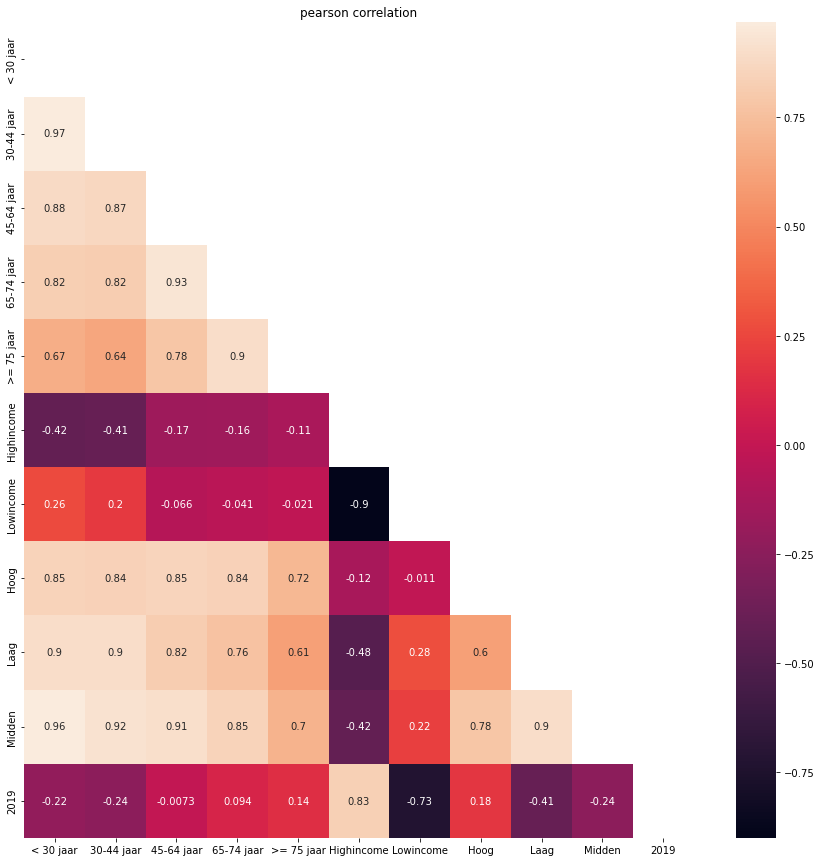

In [17]:
#@Author Matey
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_matrix(data):

    numeric_data = data.select_dtypes(include=np.number)

    corr_matrix = numeric_data.corr(method='pearson')

    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(corr_matrix,
               mask=np.triu(corr_matrix),
               ax=ax, annot=True).set_title(f'pearson correlation')
    
correlation_matrix(merged)

# Classification

In [18]:
#@Author Hubert
X = merged
y = cluster_crime

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#@Author Matey
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 10),
        'kernel': trial.suggest_categorical('kernel', ['linear']), #['linear', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'degree': trial.suggest_int('degree', 1, 5),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'probability': trial.suggest_categorical('probability', [False, True]),
        'coef0': trial.suggest_float('coef0', 0.0, 1.0),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'decision_function_shape': trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr']),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

    svc = SVC(**params)

    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print('Best hyperparameters:', best_params)
print('Best score:', best_score)

[I 2023-06-14 10:39:14,733] A new study created in memory with name: no-name-334d16fc-2131-434c-8825-590f48141f22
/home/hubert/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hubert/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=138).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[I 2023-06-14 10:39:14,866] Trial 0 finished with value: 0.9 and parameters: {'C': 2.1967925639199204, 'kernel': 'linear', 'gamma': 0.020771726032828924, 'degree': 2, 'class_weight': 'balanced', 'probability': False, 'coef0': 0.1994199502091969, 'shrinking': True, 'decision_function_shape': 'ovo', 'tol': 0.008125062377163688, 'max_iter': 138}. Best is trial 0 with value: 0.9.
/home/huber

Best hyperparameters: {'C': 2.1967925639199204, 'kernel': 'linear', 'gamma': 0.020771726032828924, 'degree': 2, 'class_weight': 'balanced', 'probability': False, 'coef0': 0.1994199502091969, 'shrinking': True, 'decision_function_shape': 'ovo', 'tol': 0.008125062377163688, 'max_iter': 138}
Best score: 0.9


In [20]:
#@Author Hubert, Maikel
from sklearn.model_selection import cross_val_score

# Create an instance of the SVM classifier with best parameters
svm = SVC(**best_params)

#scores = cross_val_score(svm, X_test, y_test, cv=5)
#print(scores)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Make predictions on the testing data
predictions = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9


/home/hubert/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hubert/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=138).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [21]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [22]:
y_test

,CrimeRateLabel
Mastbos,0
Tuinzigt,0
Liesbos,0
Waterdonken,0
Kievitsloop,0
Station,0
Effen-Rith,0
Heilaar,0
Boeimeer,0
Kroeten,0


In [23]:
svm.coef_

array([[ 1.90809909e-03, -2.62260045e-03, -1.47945216e-03,
        -3.62245372e-04, -2.84298988e-03,  6.87829484e-05,
        -1.22363620e-04, -1.11687656e-03, -2.19911791e-03,
         3.54470518e-03,  2.72829286e-06]])

In [25]:
#Store column names as list
feature_names = X.columns.tolist()
# class_names = ['Class 1', 'Class 2', 'Class 3']
#class_names = ['low crime', 'mid crime', 'high crime']

#try:
result = f_importances(svm.coef_, feature_names, class_names)
#except:
#    print('Could not calculate coeficients, most likely problem is that SVM kernel is NOT set to "linear"')


# Printing the assigned coefficients
for class_name, coefficients in result.items():
    print(f'Class: {class_name}')
    for feature_name, coefficient in coefficients.items():
        print(f'{feature_name}: {coefficient}')
    print()

NameError: name 'class_names' is not defined

In [26]:
plot_coefficients(svm.coef_, feature_names, class_names)

NameError: name 'class_names' is not defined

In [27]:
# min = np.array(svm.coef_.min())
# max = np.array(svm.coef_.max())
# min, max

t = svm.coef_




In [ ]:
# plot_coefficients(coef, feature_names, class_names):
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5  # Width of each bar
space_between_bars = 0.05  # Space between bars for different classes

# Iterate over each class

# Calculate the x-position for each bar, adding appropriate spacing
x_pos = np.arange(len(feature_names)) + (bar_width + space_between_bars)

# Plot the horizontal bars for the current class
ax.barh(x_pos, svm.coef_[1], height=bar_width, align='center', label='low_crime')

# Set the y-ticks and labels to the feature names
ax.set_yticks(np.arange(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.legend()  # Add a legend to the plot
ax.set_xlabel('Coefficient Value')  # Set the x-axis label
ax.set_title('Coefficients for Each Class')  # Set the plot title

# plt.xticks(t.min(), t.max())  # arbitrary chosen
plt.show()  # Display the plot

In [ ]:
# plot_coefficients(coef, feature_names, class_names):
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2  # Width of each bar
space_between_bars = 0.05  # Space between bars for different classes

# Iterate over each class

# Calculate the x-position for each bar, adding appropriate spacing
# x_pos = np.arange(len(feature_names)) + (bar_width + space_between_bars)

# Plot the horizontal bars for the current class
ax.barh(x_pos, svm.coef_[2], height=bar_width, align='center', label='mid_crime', color='orange')

# Set the y-ticks and labels to the feature names
ax.set_yticks(np.arange(len(feature_names)))
ax.set_yticklabels(feature_names)

ax.legend()  # Add a legend to the plot
ax.set_xlabel('Coefficient Value')  # Set the x-axis label
ax.set_title('Coefficients for Each Class')  # Set the plot title
plt.show()  # Display the plot